Tests the CheapFake module in cheapfake.contrib.models.CheapFake, in particular the loading of LipNet and FAN.

In [47]:
import os
import time
import warnings

import cv2
import torch
import numpy as np
import cheapfake.contrib.dataset as dataset
from cheapfake.contrib.models import CheapFake
import cheapfake.contrib.transforms as transforms

In [48]:
cheapfake_model = CheapFake(input_size=(64, 128))

In [49]:
random_seed = 41
root_path = "/Users/shu/Documents/Datasets/DFDC_sample/test"

dfdataset = dataset.DeepFakeDataset(root_path=root_path, return_tensor=True, random_seed=random_seed, sequential_frames=True, sequential_audio=True, stochastic=True, frame_transform=transforms.BatchRescale(output_size=4))
frames, audio, audio_stft = dfdataset.__getitem__(0)
frames = frames[None, :, :, :,].float()
print(frames.shape)
predictions = cheapfake_model(frames)

print(len(predictions))
print(predictions)

torch.Size([1, 3, 90, 270, 480])
[INFO] Starting foward pass
[INFO] Finished convolution layer 1
[INFO] Finished convolution layer 2
[INFO] Finished convolution layer 3


RuntimeError: input.size(-1) must be equal to input_size. Expected 3072, got 46080

Maybe you are getting the above error because there is no prediction?

In [4]:
image = frames[0]
image = np.einsum("ijkl->jikl", image.numpy())
image = np.einsum("ijkl->iklj", image)

image = torch.from_numpy(image[0])
print(image.shape)
predictions = cheapfake_model.face_alignment_model.get_landmarks_from_image(image)
print(np.array(predictions).shape)

torch.Size([270, 480, 3])
(1, 68, 2)


In [5]:
# Perform adaptive histogram equalization
lab_image = cv2.cvtColor(np.uint8(image.numpy()), cv2.COLOR_RGB2LAB)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
lab_image[:,:,0] = clahe.apply(lab_image[:,:,0])
image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

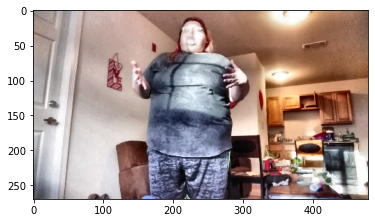

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(image.astype("uint8"))

There are some videos that are actually really really bad with lighting. Let's see if histogram equalization can help.
VID ID: adhsbajydo

In [7]:
import cheapfake.contrib.video_processor as video_processor

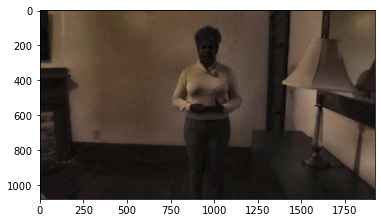

In [35]:
video_path = "/Users/shu/Documents/Datasets/DFDC_sample/train/train_sample_videos/adhsbajydo.mp4"
videofile_processor = video_processor.VideoFileProcessor()
frames = videofile_processor.extract_all_frames(video_path=video_path, channel_first=False, return_rgb=True)

image = frames[0]
lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
lab_image[:,:,0] = clahe.apply(lab_image[:,:,0])
ahe_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

fig = plt.figure()
plt.imshow(ahe_image)

(1, 68, 2)


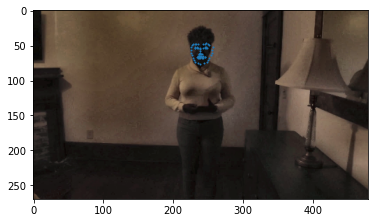

In [38]:
# Even with this lighting condition, are we able to detect faces? Let's see.
new_height = int(ahe_image.shape[0] / 4)
new_width = int(ahe_image.shape[1] / 4)
ahe_resized = cv2.resize(ahe_image, dsize=(new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
ahe_resized = torch.from_numpy(ahe_resized)

predictions = cheapfake_model.face_alignment_model.get_landmarks_from_image(ahe_resized)
predictions = np.array(predictions)
print(predictions.shape)

# Plot the predictions. 
fig = plt.figure()
plt.imshow(ahe_resized)
plt.scatter(predictions[0][:,0], predictions[0][:,1], s=1)


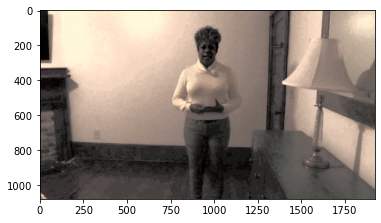

In [40]:
# Let's also try global histogram equalization.
video_path = "/Users/shu/Documents/Datasets/DFDC_sample/train/train_sample_videos/adhsbajydo.mp4"
videofile_processor = video_processor.VideoFileProcessor()
frames = videofile_processor.extract_all_frames(video_path=video_path, channel_first=False, return_rgb=True)

image = frames[0]
lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
lab_image[:,:,0] = cv2.equalizeHist(lab_image[:,:,0])
eq_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

fig = plt.figure()
plt.imshow(eq_image)

(1, 68, 2)


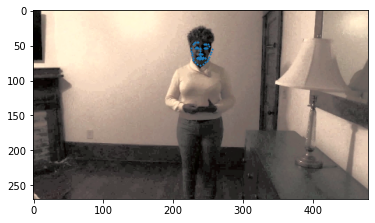

In [41]:
# Even with this lighting condition, are we able to detect faces? Let's see.
new_height = int(eq_image.shape[0] / 4)
new_width = int(eq_image.shape[1] / 4)
eq_resized = cv2.resize(eq_image, dsize=(new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
eq_resized = torch.from_numpy(eq_resized)

predictions = cheapfake_model.face_alignment_model.get_landmarks_from_image(eq_resized)
predictions = np.array(predictions)
print(predictions.shape)

# Plot the predictions. 
fig = plt.figure()
plt.imshow(eq_resized)
plt.scatter(predictions[0][:,0], predictions[0][:,1], s=1)

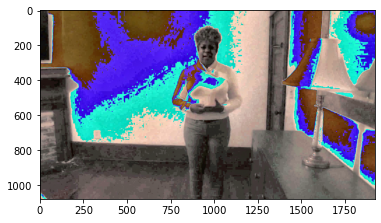

In [23]:
image = (ahe_image + eq_image) / 255

fig = plt.figure()
plt.imshow(image)

OK, so it looks like first we need to send the resized image into FAN to get the facial landmarks. Those facial landmarks are then used to extract the lip region, which then gets resized to 64 x 128 for LipNet. When ResNet starts working, we can integrate that information in as well. 

So workflow:
Resized Frames get sent (in FAN convention) to the network. The predictions are then obtained. The predictions are then used to grab the approximate lip region, to extract from the FULL frame (with some sort of buffer). This extracted lip region gets resized to (64 x 128) and then fed through to LipNet. The facial features extracted from the FAN also get fed into the MLP along with the embeddings from the audio and the LipNet.